The SAT, or Scholastic Aptitude Test, is an exam that U.S. high school students take before applying to college. Colleges take the test scores into account when deciding who to admit, so it's fairly important to perform well on it.

The test consists of three sections, each of which has 800 possible points. The combined score is out of 2,400 possible points (while this number has changed a few times, the data set for our project is based on 2,400 total points). Organizations often rank high schools by their average SAT scores. The scores are also considered a measure of overall school district quality.

New York City makes its [data on high school SAT scores available online](https://data.cityofnewyork.us/Education/2012-SAT-Results/f9bf-2cp4), as well as the demographics for each high school.

A list of data sets will be used for this project.

In [2]:
import pandas as pd
# import reg exp lib
import re
import numpy
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap

data_files = [
    "ap_2010.csv",
    "class_size.csv",
    "demographics.csv",
    "graduation.csv",
    "hs_directory.csv",
    "sat_results.csv"
]

data = {}
for file in data_files:
    d = pd.read_csv(file)
    key = file.replace('.csv','')
    data[key] = d

# Read Surveys

In [3]:
all_survey = pd.read_csv('survey_all.txt',delimiter="\t",encoding="windows-1252")
d75_survey = pd.read_csv('survey_d75.txt',delimiter="\t",encoding="windows-1252")
survey = pd.concat([all_survey,d75_survey],axis=0,sort=False)
survey['DBN'] = survey['dbn']

# only select certain cols
survey_fields = ["DBN", "rr_s", "rr_t", "rr_p", "N_s", "N_t", "N_p", "saf_p_11", "com_p_11", "eng_p_11", "aca_p_11", "saf_t_11", "com_t_11", "eng_t_11", "aca_t_11", "saf_s_11", "com_s_11", "eng_s_11", "aca_s_11", "saf_tot_11", "com_tot_11", "eng_tot_11", "aca_tot_11"]
# add to dict data
survey = survey[survey_fields]
data['survey'] = survey

# Add DBN columns

In [4]:
data['hs_directory']['DBN'] = data['hs_directory']['dbn']
def padd(row):
    s = str(row["CSD"])
    if len(s) < 2:
        s = s.zfill(2)
    new_col_val = s + row["SCHOOL CODE"]     
    return new_col_val

#pass each row to the padd() function to pad CSD col value with leading zeros        
data['class_size']['DBN'] = data['class_size'].apply(padd, axis=1) 

# Convert columns to numeric

In [5]:
cols = ['SAT Math Avg. Score', 'SAT Critical Reading Avg. Score', 'SAT Writing Avg. Score']
for c in cols:
    data["sat_results"][c] = pd.to_numeric(data["sat_results"][c], errors="coerce")
data['sat_results']['sat_score'] = data['sat_results']['SAT Critical Reading Avg. Score'] + data['sat_results']['SAT Math Avg. Score'] + data['sat_results']['SAT Writing Avg. Score']

def extr(row):
    lat = re.findall("\(.+\)", row["Location 1"])
    return lat[0][1:lat[0].index(',')]
    
#pass each row to the extr() function to extract lat        
data['hs_directory']['lat'] = data['hs_directory'].apply(extr, axis=1) 

def extrL(row):
    lat = re.findall("\(.+\)", row["Location 1"])
    return lat[0][lat[0].index(',')+1:len(lat[0])-2].strip()
    
#pass each row to the extr() function to extract long        
data['hs_directory']['lon'] = data['hs_directory'].apply(extrL, axis=1) 

data['hs_directory']['lat'] = pd.to_numeric(data['hs_directory']['lat'], errors="coerce")
data['hs_directory']['lon'] = pd.to_numeric(data['hs_directory']['lon'], errors="coerce")

# Condense datasets

In [6]:
class_size = data["class_size"]
class_size = class_size[(class_size['GRADE '] == '09-12') & (class_size['PROGRAM TYPE'] == 'GEN ED')]

class_size = class_size.groupby("DBN").agg(numpy.mean)
class_size.reset_index(inplace=True)
data["class_size"] = class_size

demographics = data["demographics"]
data["demographics"] = demographics[demographics['schoolyear'] == 20112012]

graduation = data['graduation']
data['graduation'] = graduation[(graduation['Cohort']== '2006') & (graduation['Demographic'] =='Total Cohort')]

# Convert AP scores to numeric

In [7]:
cols = ['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']
for c in cols:
    data['ap_2010'] [c] = pd.to_numeric(data["ap_2010"][c], errors="coerce")

# Combine the datasets

In [8]:
combined = data["sat_results"]
combined = combined.merge(data['ap_2010'], how='left', on='DBN')
combined = combined.merge(data['graduation'], how='left', on='DBN')

combined = combined.merge(data['class_size'], how='inner', on='DBN')
combined = combined.merge(data['demographics'], how='inner', on='DBN')
combined = combined.merge(data['survey'], how='inner', on='DBN')
combined = combined.merge(data['hs_directory'], how='inner', on='DBN')

means = combined.mean()
combined = combined.fillna(means)
combined = combined.fillna(0)

# Add a school district column for mapping

In [9]:
def sd(col):
    return col[0:2]

combined["school_dist"] = combined["DBN"].apply(sd)

# Find correlations

In [10]:
# Use the pandas.DataFrame.corr() method on the combined dataframe to find all possible correlations. 
# Assign the result to correlations.
# Filter correlations so that it only shows correlations for the column sat_score.
# Display all of the rows in correlations and look them over.
correlations = combined.corr()
correlations = correlations["sat_score"]
print(correlations)

SAT Critical Reading Avg. Score         0.986820
SAT Math Avg. Score                     0.972643
SAT Writing Avg. Score                  0.987771
sat_score                               1.000000
AP Test Takers                          0.523140
Total Exams Taken                       0.514333
Number of Exams with scores 3 4 or 5    0.463245
Total Cohort                            0.325144
CSD                                     0.042948
NUMBER OF STUDENTS / SEATS FILLED       0.394626
NUMBER OF SECTIONS                      0.362673
AVERAGE CLASS SIZE                      0.381014
SIZE OF SMALLEST CLASS                  0.249949
SIZE OF LARGEST CLASS                   0.314434
SCHOOLWIDE PUPIL-TEACHER RATIO               NaN
schoolyear                                   NaN
fl_percent                                   NaN
frl_percent                            -0.722225
total_enrollment                        0.367857
ell_num                                -0.153778
ell_percent         

# Plotting survey correlations

In [11]:
# Remove DBN since it's a unique identifier, not a useful numerical value for correlation.
survey_fields.remove("DBN")

IPython has a set of predefined ‘magic functions’ that you can call with a command line style syntax. There are two kinds of magics, line-oriented and cell-oriented. Line magics are prefixed with the % character and work much like OS command-line calls: they get as an argument the rest of the line, where arguments are passed without parentheses or quotes. Lines magics can return results and can be used in the right hand side of an assignment. Cell magics are prefixed with a double %%, and they are functions that get as an argument not only the rest of the line, but also the lines below it in a separate argument.

%matplotlib inline sets the backend of matplotlib to the 'inline' backend:

With this backend, the output of plotting commands is displayed inline within frontends like the Jupyter notebook, directly below the code cell that produced it. The resulting plots will then also be stored in the notebook document.

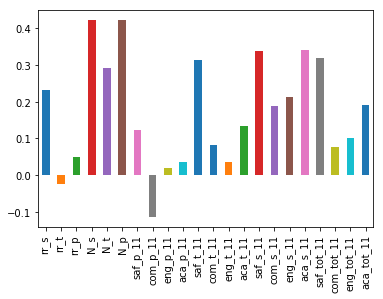

In [12]:
%matplotlib inline
combined.corr()["sat_score"][survey_fields].plot.bar()

Observations:
Strong +ve correlation between sat_scores and N_s and N_p

There are high correlations between N_s, N_t, N_p and sat_score. Since these columns are correlated with total_enrollment, 
it makes sense that they would be high.
It is more interesting that rr_s, the student response rate, or the percentage of students that completed the survey, 
correlates with sat_score. This might make sense because students who are more likely to fill out surveys may be more 
likely to also be doing well academically.

How students and teachers percieved safety (saf_t_11 and saf_s_11) correlate with sat_score. This make sense, as it's hard 
to teach or learn in an unsafe environment.

The last interesting correlation is the aca_s_11, which indicates how the student perceives academic standards, correlates 
with sat_score, but this is not true for aca_t_11, how teachers perceive academic standards, or aca_p_11, how parents 
perceive academic standards.

On the last screen, you may have noticed that saf_t_11 and saf_s_11, which measure how teachers and students perceive safety
at school, correlated highly with sat_score. On this screen, we'll dig into this relationship a bit more, and try to figure 
out which schools have low safety scores.

Investigate safety scores.
Make a scatter plot of the saf_s_11 column vs. the sat_score in combined.
Write up your conclusions about safety and SAT scores in a Markdown cell.
Map out safety scores.
Compute the average safety score for each district.
Make a map that shows safety scores by district.
Write up your conclusions about safety by geographic area in a Markdown cell. You may want to read up on the boroughs of 
New York City.

# Exploring Safety

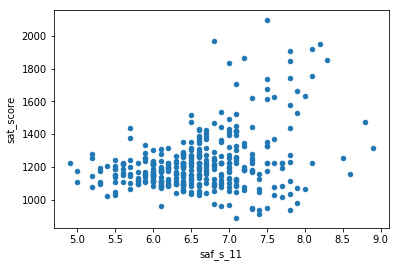

In [13]:
combined.plot.scatter("saf_s_11", "sat_score")

Observations:

There appears to be a correlation between SAT scores and safety, although it isn't thatstrong. It looks like there are a few schools with extremely high SAT scores and high safety scores. There are a few schools with low safety scores and low SAT scores. No school with a safety score lower than 6.5 has an average SAT score higher than 1500 or so.

There are a few columns that indicate the percentage of each race at a given school:

white_per
asian_per
black_per
hispanic_per
By plotting out the correlations between these columns and sat_score, we can determine whether there are any racial differences in SAT performance.

Instructions
Investigate racial differences in SAT scores.
Make a bar plot of the correlations between the columns above and sat_score.
Write up a Markdown cell containing your findings. Are there any unexpected correlations?

# Plotting safety

C:\Users\NS-PC\Anaconda3\lib\site-packages\mpl_toolkits\basemap\__init__.py:1708: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
C:\Users\NS-PC\Anaconda3\lib\site-packages\mpl_toolkits\basemap\__init__.py:1711: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  if limb is not ax.axesPatch:


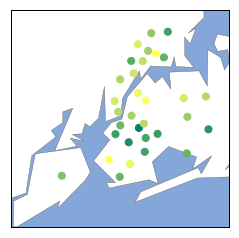

In [22]:
districts = combined.groupby("school_dist").agg(numpy.mean)
districts.reset_index(inplace=True)

m = Basemap(
    projection='merc', 
    llcrnrlat=40.496044, 
    urcrnrlat=40.915256, 
    llcrnrlon=-74.255735, 
    urcrnrlon=-73.700272,
    resolution='i'
)

m.drawmapboundary(fill_color='#85A6D9')
m.drawcoastlines(color='#6D5F47', linewidth=.4)
m.drawrivers(color='#6D5F47', linewidth=.4)
m.fillcontinents(color='white',lake_color='#85A6D9')

longitudes = districts["lon"].tolist()
latitudes = districts["lat"].tolist()
m.scatter(longitudes, latitudes, s=50, zorder=2, latlon=True, c=districts["saf_s_11"], cmap="summer")
plt.show()
# It looks like Upper Manhattan and parts of Queens and the Bronx tend to have higher safety scores, whereas Brooklyn has 
# low safety scores.

# known warning

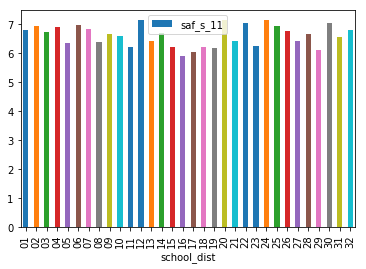

In [15]:
districts.plot.bar('school_dist','saf_s_11')

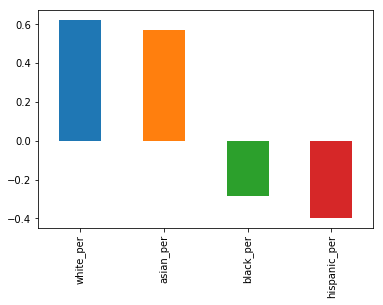

In [16]:
race_columns = ['white_per',
'asian_per',
'black_per',
'hispanic_per']
combined.corr()["sat_score"][race_columns].plot.bar()

Observations:
There is a disparity. White and Asian students perform well on the sat compared to black and hispanic. Hispaninc students perform lower compared to black students.

It looks like a higher percentage of white or asian students at a school correlates positively with sat score, whereas a higher percentage of black or hispanic students correlates negatively with sat score. This may be due to a lack of funding for schools in certain areas, which are more likely to have a higher percentage of black or hispanic students.

Explore schools with low SAT scores and high values for hispanic_per.
Make a scatter plot of hispanic_per vs. sat_score.
What does the scatter plot show? Record any interesting observsations in a Markdown cell.

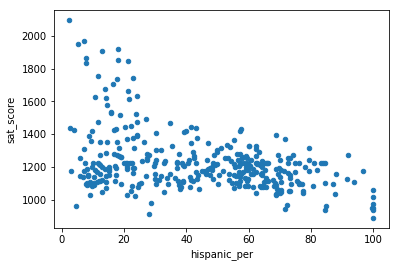

In [17]:
combined.plot.scatter("hispanic_per", "sat_score")

Research any schools with a hispanic_per greater than 95%.
Find the school names in the data.
Use Wikipedia and Google to research the schools by name.
Is there anything interesting about these particular schools? Record your findings in a Markdown cell.
Research any schools with a hispanic_per less than 10% and an average SAT score greater than 1800.
Find the school names in the data.
Use Wikipedia and Google to research the schools by name.
Is there anything interesting about these particular schools? Record your findings in a Markdown cell.

In [18]:
print(combined[combined["hispanic_per"] > 95]["SCHOOL NAME"])
 
# The schools listed below appear to primarily be geared towards recent immigrants to the US. These schools have a lot of 
# students who are learning English, which would explain the lower SAT scores.

44                         MANHATTAN BRIDGES HIGH SCHOOL
82      WASHINGTON HEIGHTS EXPEDITIONARY LEARNING SCHOOL
89     GREGORIO LUPERON HIGH SCHOOL FOR SCIENCE AND M...
125                  ACADEMY FOR LANGUAGE AND TECHNOLOGY
141                INTERNATIONAL SCHOOL FOR LIBERAL ARTS
176     PAN AMERICAN INTERNATIONAL HIGH SCHOOL AT MONROE
253                            MULTICULTURAL HIGH SCHOOL
286               PAN AMERICAN INTERNATIONAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object


In [19]:
print(combined[(combined["hispanic_per"] < 10) & (combined["sat_score"] > 1800)]["SCHOOL NAME"])
# Many of the schools below appear to be specialized science and technology schools that receive extra funding, and only 
# admit students who pass an entrance exam. This doesn't explain the low hispanic_per, but it does explain why their students 
# tend to do better on the SAT -- they are students from all over New York City who did well on a standardized test.

37                                STUYVESANT HIGH SCHOOL
151                         BRONX HIGH SCHOOL OF SCIENCE
187                       BROOKLYN TECHNICAL HIGH SCHOOL
327    QUEENS HIGH SCHOOL FOR THE SCIENCES AT YORK CO...
356                  STATEN ISLAND TECHNICAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object


# Gender differences in SAT scores

There are two columns that indicate the percentage of each gender at a school:

male_per
female_per
We can plot out the correlations between each percentage and sat_score.

Instructions

Investigate gender differences in SAT scores.
Make a bar plot of the correlations between the columns above and sat_score.
Record your findings in a Markdown cell. Are there any unexpected correlations?

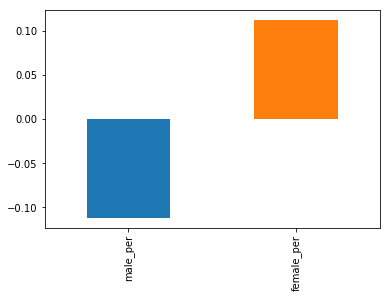

In [20]:
combined.corr()["sat_score"][['male_per','female_per']].plot.bar()

Observations:
In the plot above, we can see that a high percentage of females at a school positively correlates with SAT score, whereas a high percentage of males at a school negatively correlates with SAT score. Neither correlation is extremely strong.

Investigate schools with high SAT scores and a high female_per.
Make a scatter plot of female_per vs. sat_score.
What does the scatter plot show? Record any interesting observations in a Markdown cell.

In [ ]:
combined.plot.scatter("female_per", "sat_score")

Research any schools with a female_per greater than 60% and an average SAT score greater than 1700.
Find the school names in the data.
Use Wikipedia and Google to research the schools by name.
Is there anything interesting about these particular schools? Record your findings in a Markdown cell.

In [ ]:
print(combined[(combined["female_per"] > 60) & (combined['sat_score'] > 1700)]["SCHOOL NAME"])
# These schools appears to be very selective liberal arts schools that have high academic standards.

In the U.S., high school students take Advanced Placement (AP) exams to earn college credit. There are AP exams for many 
different subjects.

It makes sense that the number of students at a school who took AP exams would be highly correlated with the school's 
SAT scores. Let's explore this relationship. Because total_enrollment is highly correlated with sat_score, we don't want 
to bias our results. Instead, we'll look at the percentage of students in each school who took at least one AP exam.

Instructions

Calculate the percentage of students in each school that took an AP exam.
Divide the AP Test Takers column by the total_enrollment column.
The column name AP Test Takers has a space at the end -- don't forget to add it!
Assign the result to the ap_per column.
Investigate the relationship between AP scores and SAT scores.
Make a scatter plot of ap_per vs. sat_score.
What does the scatter plot show? Record any interesting observations in a Markdown cell.

In [ ]:
combined['ap_per'] = combined['AP Test Takers ']/combined['total_enrollment']
combined.plot.scatter(x='ap_per', y='sat_score')

# It looks like there is a relationship between the percentage of students in a school who take the AP exam, and their 
# average SAT scores. It's not an extremely strong correlation, though.

# Next Steps 

* Determing whether there's a correlation between class size and SAT scores
* Figuring out which neighborhoods have the best schools
* If we combine this information with a dataset containing property values, we could find the least expensive neighborhoods that have good schools.
* Investigating the differences between parent, teacher, and student responses to surveys.
* Assigning scores to schools based on sat_score and other attributes.

In [24]:
combined.to_csv('combined.csv')

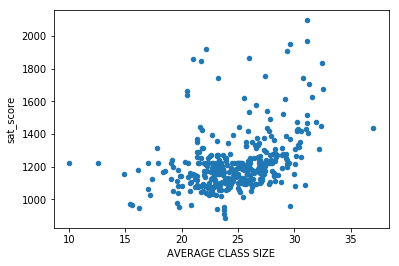

In [25]:
combined.plot.scatter(x='AVERAGE CLASS SIZE',y='sat_score')

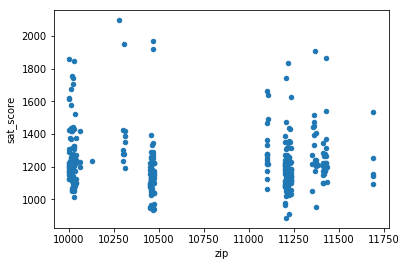

In [26]:
combined.plot.scatter(x='zip',y='sat_score')